# Projeto Final – Monitoramento da Qualidade do Ar com IA (Dados Simulados de IoT)

Este notebook implementa uma aplicação simples que:
- simula dados de sensores IoT de qualidade do ar em ambientes internos;
- permite avançar o tempo hora a hora e ajustar manualmente os parâmetros dos sensores;
- a cada hora avançada (botão Tempo +), os sensores captam automaticamente 12 amostras dos parâmetros (temperatura, umidade, CO₂);
- utiliza um modelo de IA para classificar a qualidade do ar e sugerir ações.

Os conteúdos dos módulos de IoT, Big Data e IA são utilizados ao longo das etapas do notebook.

## 1. Instalação e importação de bibliotecas

Esta célula instala (se necessário) e importa as bibliotecas Python usadas no projeto:
- `pandas` e `numpy` para manipulação de dados;
- `scikit-learn` para o modelo de IA;
- `matplotlib` e `seaborn` para visualizações;
- `ipywidgets` para criar botões e controles interativos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from ipywidgets import widgets, HBox, VBox, Output
from IPython.display import display, clear_output

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Definição da legenda de qualidade do ar

Nesta célula definimos os limites de CO₂ (ppm) para classificar a qualidade do ar:
- **Excelente**: CO₂ ≤ 600 ppm  
- **Bom**: 600 < CO₂ ≤ 1000 ppm  
- **Ruim**: 1000 < CO₂ ≤ 1500 ppm  
- **Péssimo**: CO₂ > 1500 ppm  

Esses limites serão usados para rotular a classe de qualidade do ar.

In [2]:
def classificar_por_co2(co2_val):
    if co2_val <= 600:
        return "Excelente"
    elif co2_val <= 1000:
        return "Bom"
    elif co2_val <= 1500:
        return "Ruim"
    else:
        return "Péssimo"

print("Legenda de qualidade do ar baseada em CO₂ (ppm):")
print("  - Excelente: CO₂ ≤ 600")
print("  - Bom      : 600 < CO₂ ≤ 1000")
print("  - Ruim     : 1000 < CO₂ ≤ 1500")
print("  - Péssimo  : CO₂ > 1500")

Legenda de qualidade do ar baseada em CO₂ (ppm):
  - Excelente: CO₂ ≤ 600
  - Bom      : 600 < CO₂ ≤ 1000
  - Ruim     : 1000 < CO₂ ≤ 1500
  - Péssimo  : CO₂ > 1500


## 3. Função para gerar dados de treinamento do modelo de IA

Aqui criamos uma função que simula dados históricos como se viessem de sensores IoT ao longo de vários dias.

Cada linha da base conterá:
- `timestamp`
- `hora_do_dia`
- `dia_da_semana`
- `ocupacao` (0 = sem pessoas, 1 = com pessoas no ambiente)
- `temperatura`
- `umidade`
- `co2`
- `classe_qualidade` (Excelente, Bom, Ruim, Péssimo)

Esses dados serão usados para treinar o modelo de IA.

In [6]:
def gerar_dados_treinamento(n_dias=10, seed=42):
    np.random.seed(seed)

    registros_por_dia = 24
    total_registros = n_dias * registros_por_dia

    timestamps = pd.date_range(
        start="2024-01-01",
        periods=total_registros,
        freq="H"
    )

    hora_do_dia = timestamps.hour
    dia_da_semana = timestamps.dayofweek

    ocupacao = []
    for h, d in zip(hora_do_dia, dia_da_semana):
        if d < 5 and 8 <= h <= 18:
            ocupacao.append(np.random.choice([0, 1], p=[0.2, 0.8]))
        else:
            ocupacao.append(np.random.choice([0, 1], p=[0.8, 0.2]))
    ocupacao = np.array(ocupacao)

    base_temp = 23 + 4 * np.sin((hora_do_dia - 8) * np.pi / 12)
    temperatura = base_temp + np.random.normal(0, 1.0, total_registros)

    umidade = 50 + 10 * np.sin((hora_do_dia - 12) * np.pi / 12)
    umidade += np.random.normal(0, 5.0, total_registros)
    umidade = np.clip(umidade, 20, 90)

    co2 = 500 + ocupacao * np.random.normal(600, 200, total_registros)
    co2 += np.maximum(0, (hora_do_dia - 18)) * 30
    co2 = np.clip(co2, 400, 2500)

    classe_qualidade = [classificar_por_co2(v) for v in co2]

    df = pd.DataFrame({
        "timestamp": timestamps,
        "hora_do_dia": hora_do_dia,
        "dia_da_semana": dia_da_semana,
        "ocupacao": ocupacao,
        "temperatura": temperatura,
        "umidade": umidade,
        "co2": co2,
        "classe_qualidade": classe_qualidade
    })

    return df

df_treino = gerar_dados_treinamento(n_dias=30)
print(f"Dados de treinamento gerados: {len(df_treino)} registros")
df_treino.head()

Dados de treinamento gerados: 720 registros


/tmp/ipython-input-1475809653.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(


,timestamp,hora_do_dia,dia_da_semana,ocupacao,temperatura,umidade,co2,classe_qualidade
0,2024-01-01 00:00:00,0,0,0,19.622488,55.456551,500.000000,Excelente
1,2024-01-01 01:00:00,1,0,1,18.980619,50.457500,1250.858266,Ruim
2,2024-01-01 02:00:00,2,0,0,20.167782,39.538436,500.000000,Excelente
3,2024-01-01 03:00:00,3,0,0,19.390718,41.346890,500.000000,Excelente
4,2024-01-01 04:00:00,4,0,0,19.873501,47.405234,500.000000,Excelente


## 4. Análise exploratória dos dados de treinamento

Esta célula:
- mostra estatísticas descritivas das variáveis numéricas;
- exibe a contagem de registros em cada classe de qualidade do ar;
- plota um gráfico de CO₂ ao longo do tempo.

Essas análises se conectam ao conteúdo de Big Data e estatística descritiva.

Estatísticas descritivas:


,temperatura,umidade,co2
count,720.000000,720.000000,720.000000
mean,23.077826,50.281861,755.335406
std,2.981992,8.834721,315.543873
min,16.839012,25.638799,496.097569
25%,20.461167,43.846253,500.000000
50%,23.063828,50.305228,560.000000
75%,25.713638,57.331126,1041.748504
max,29.496085,72.759810,1697.051801



Distribuição das classes de qualidade do ar:


,count
classe_qualidade,
Excelente,391
Ruim,191
Bom,129
Péssimo,9


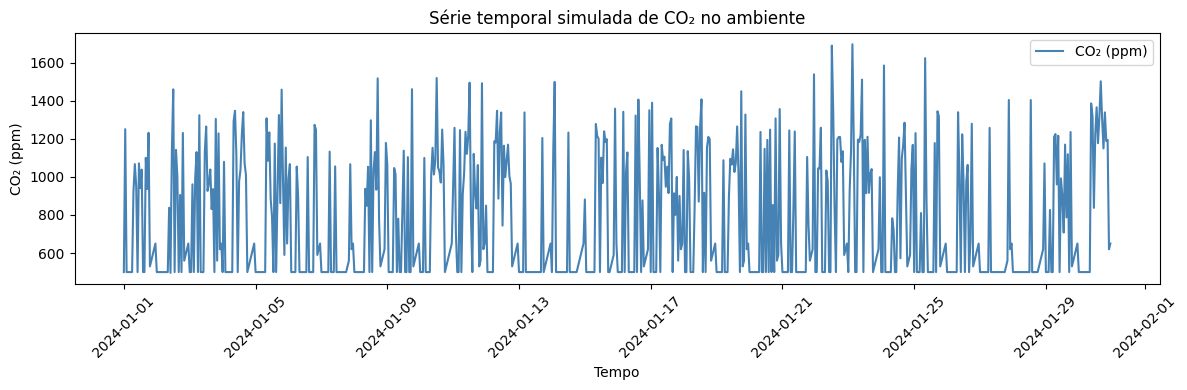

In [7]:
print("Estatísticas descritivas:")
display(df_treino[["temperatura", "umidade", "co2"]].describe())

print("\nDistribuição das classes de qualidade do ar:")
display(df_treino["classe_qualidade"].value_counts())

plt.figure(figsize=(12, 4))
plt.plot(df_treino["timestamp"], df_treino["co2"], label="CO₂ (ppm)", color="steelblue")
plt.xlabel("Tempo")
plt.ylabel("CO₂ (ppm)")
plt.title("Série temporal simulada de CO₂ no ambiente")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Treinamento do modelo de IA

Aqui preparamos os dados e treinamos um modelo de classificação:
- selecionamos as features de entrada (hora, dia da semana, ocupação, temperatura e umidade);
- usamos a `classe_qualidade` como rótulo (variável alvo);
- dividimos em conjuntos de treino e teste;
- treinamos um `RandomForestClassifier` para prever a classe de qualidade do ar.

Essa etapa representa a aplicação de IA sobre dados de IoT.

Relatório de classificação:
              precision    recall  f1-score   support

         Bom       0.74      0.44      0.55        32
   Excelente       1.00      1.00      1.00        98
     Péssimo       0.00      0.00      0.00         2
        Ruim       0.68      0.90      0.77        48

    accuracy                           0.86       180
   macro avg       0.60      0.58      0.58       180
weighted avg       0.86      0.86      0.85       180



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


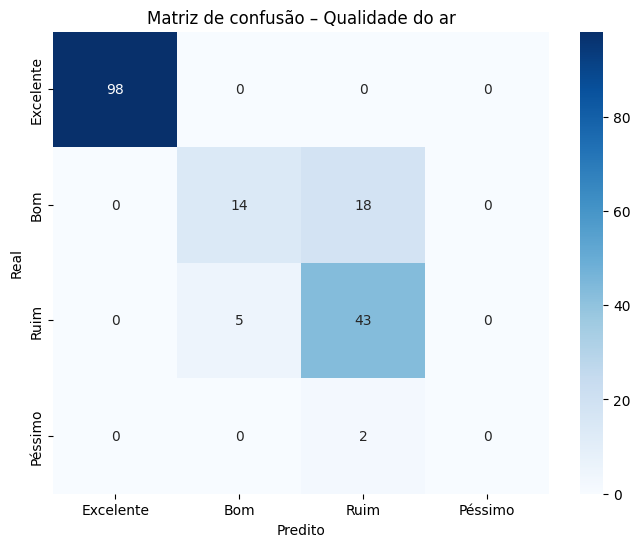


Modelo treinado com sucesso!


In [8]:
y = df_treino["classe_qualidade"]
X = df_treino[["hora_do_dia", "dia_da_semana", "ocupacao", "temperatura", "umidade"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

modelo = RandomForestClassifier(n_estimators=200, random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print("Relatório de classificação:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Excelente", "Bom", "Ruim", "Péssimo"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Excelente", "Bom", "Ruim", "Péssimo"],
            yticklabels=["Excelente", "Bom", "Ruim", "Péssimo"],
            cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de confusão – Qualidade do ar")
plt.show()

print("\nModelo treinado com sucesso!")

## 6. Interface interativa de simulação

Nesta célula criamos uma interface interativa com:
- Controles deslizantes para ajustar manualmente temperatura, umidade e CO₂;
- Botão **Tempo +** para avançar uma hora e gerar automaticamente 12 amostras de leituras dos sensores;
- Visualização em tempo real dos dados coletados e da classificação de qualidade do ar pelo modelo de IA.

A cada vez que o botão Tempo + é pressionado:
- O tempo avança 1 hora
- São geradas automaticamente 12 amostras com pequenas variações aleatórias em torno dos valores ajustados
- Exemplo: 3 cliques = 3 horas = 36 amostras totais

In [11]:
# Estado da simulação
estado = {
    "hora_atual": 8,
    "dia_semana": 2,  # quarta-feira
    "ocupacao": 1,
    "timestamp_inicial": datetime(2024, 11, 20, 8, 0, 0),
    "dados_coletados": []
}

# Widgets de controle
slider_temp = widgets.FloatSlider(
    value=24.0, min=15.0, max=35.0, step=0.5,
    description='Temp (°C):',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

slider_umid = widgets.FloatSlider(
    value=55.0, min=20.0, max=90.0, step=1.0,
    description='Umidade (%):',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

slider_co2 = widgets.FloatSlider(
    value=800.0, min=400.0, max=2500.0, step=50.0,
    description='CO₂ (ppm):',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

btn_tempo = widgets.Button(
    description='Tempo +',
    button_style='info',
    layout=widgets.Layout(width='120px')
)

btn_resetar = widgets.Button(
    description='Resetar',
    button_style='warning',
    layout=widgets.Layout(width='120px')
)

output_info = Output()
output_grafico = Output()
output_alertas = Output()

def atualizar_info():
    with output_info:
        clear_output(wait=True)
        timestamp_atual = estado["timestamp_inicial"] + timedelta(hours=estado["hora_atual"] - 8)
        print(f"Data/Hora atual: {timestamp_atual.strftime('%Y-%m-%d %H:%M')}")
        print(f"Hora do dia: {estado['hora_atual']}h")
        print(f"Dia da semana: {['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'][estado['dia_semana']]}")
        print(f"Ocupação: {'Sim' if estado['ocupacao'] == 1 else 'Não'}")
        print(f"\nTotal de amostras coletadas: {len(estado['dados_coletados'])}")
        print(f"Total de horas simuladas: {len(estado['dados_coletados']) // 12}")

def exibir_alertas(temp_media, umid_media, co2_media):
    alertas = []

    # Alertas de CO2
    if co2_media > 1500:
        alertas.append({
            "tipo": "🚨 CRÍTICO - CO₂",
            "mensagem": f"Nível de CO₂ muito alto ({co2_media:.0f} ppm)!",
            "acao": "⚠️ AÇÃO URGENTE: Abra todas as janelas imediatamente e ligue a ventilação forçada!",
            "cor": "#ff4444"
        })
    elif co2_media > 1000:
        alertas.append({
            "tipo": "⚠️ ALERTA - CO₂",
            "mensagem": f"Nível de CO₂ elevado ({co2_media:.0f} ppm)",
            "acao": "💨 RECOMENDAÇÃO: Abra as janelas para ventilar o ambiente.",
            "cor": "#ff9800"
        })

    # Alertas de Temperatura
    if temp_media > 28:
        alertas.append({
            "tipo": "🌡️ ALERTA - Temperatura",
            "mensagem": f"Temperatura muito alta ({temp_media:.1f}°C)",
            "acao": "❄️ RECOMENDAÇÃO: Ligue o ar-condicionado ou ventiladores.",
            "cor": "#ff5722"
        })
    elif temp_media < 18:
        alertas.append({
            "tipo": "🌡️ ALERTA - Temperatura",
            "mensagem": f"Temperatura muito baixa ({temp_media:.1f}°C)",
            "acao": "🔥 RECOMENDAÇÃO: Ligue o aquecedor ou feche as janelas.",
            "cor": "#2196f3"
        })

    # Alertas de Umidade
    if umid_media > 70:
        alertas.append({
            "tipo": "💧 ALERTA - Umidade",
            "mensagem": f"Umidade muito alta ({umid_media:.1f}%)",
            "acao": "🌬️ RECOMENDAÇÃO: Use um desumidificador ou abra as janelas.",
            "cor": "#03a9f4"
        })
    elif umid_media < 30:
        alertas.append({
            "tipo": "💧 ALERTA - Umidade",
            "mensagem": f"Umidade muito baixa ({umid_media:.1f}%)",
            "acao": "💦 RECOMENDAÇÃO: Beba água e use um umidificador de ar.",
            "cor": "#ffc107"
        })

    # Exibir alertas
    with output_alertas:
        clear_output(wait=True)
        if alertas:
            print("=" * 80)
            print("🔔 ALERTAS E RECOMENDAÇÕES".center(80))
            print("=" * 80)
            for alerta in alertas:
                print(f"\n{alerta['tipo']}")
                print(f"{alerta['mensagem']}")
                print(f"{alerta['acao']}")
                print("-" * 80)
        else:
            print("=" * 80)
            print("✅ TUDO OK - Condições ambientais dentro dos parâmetros ideais!".center(80))
            print("=" * 80)

def gerar_amostras_hora():
    temp_base = slider_temp.value
    umid_base = slider_umid.value
    co2_base = slider_co2.value

    # Gerar 12 amostras com pequenas variações
    for i in range(12):
        timestamp_atual = estado["timestamp_inicial"] + timedelta(
            hours=estado["hora_atual"] - 8,
            minutes=i * 5
        )

        temp_amostra = temp_base + np.random.normal(0, 0.3)
        umid_amostra = np.clip(umid_base + np.random.normal(0, 2.0), 20, 90)
        co2_amostra = np.clip(co2_base + np.random.normal(0, 30), 400, 2500)

        classe = classificar_por_co2(co2_amostra)

        # Predição do modelo
        X_pred = pd.DataFrame([{
            "hora_do_dia": estado["hora_atual"],
            "dia_da_semana": estado["dia_semana"],
            "ocupacao": estado["ocupacao"],
            "temperatura": temp_amostra,
            "umidade": umid_amostra
        }])
        classe_modelo = modelo.predict(X_pred)[0]

        estado["dados_coletados"].append({
            "timestamp": timestamp_atual,
            "hora_do_dia": estado["hora_atual"],
            "dia_da_semana": estado["dia_semana"],
            "ocupacao": estado["ocupacao"],
            "temperatura": temp_amostra,
            "umidade": umid_amostra,
            "co2": co2_amostra,
            "classe_regra": classe,
            "classe_modelo": classe_modelo
        })

def on_tempo_click(b):
    # Gerar 12 amostras para a hora atual antes de avançar
    gerar_amostras_hora()

    # Calcular médias da última hora para os alertas
    ultimas_12 = estado["dados_coletados"][-12:]
    temp_media = np.mean([d["temperatura"] for d in ultimas_12])
    umid_media = np.mean([d["umidade"] for d in ultimas_12])
    co2_media = np.mean([d["co2"] for d in ultimas_12])

    # Avançar o tempo
    estado["hora_atual"] += 1
    if estado["hora_atual"] >= 24:
        estado["hora_atual"] = 0
        estado["dia_semana"] = (estado["dia_semana"] + 1) % 7

    # Ajustar ocupação automaticamente
    if estado["dia_semana"] < 5 and 8 <= estado["hora_atual"] <= 18:
        estado["ocupacao"] = 1
    else:
        estado["ocupacao"] = 0

    atualizar_info()
    atualizar_grafico()
    exibir_alertas(temp_media, umid_media, co2_media)

def on_resetar_click(b):
    # Resetar estado
    estado["hora_atual"] = 8
    estado["dia_semana"] = 2
    estado["ocupacao"] = 1
    estado["timestamp_inicial"] = datetime(2024, 11, 20, 8, 0, 0)
    estado["dados_coletados"] = []

    # Resetar sliders
    slider_temp.value = 24.0
    slider_umid.value = 55.0
    slider_co2.value = 800.0

    # Limpar outputs
    with output_grafico:
        clear_output()
    with output_alertas:
        clear_output()

    atualizar_info()
    print("\n✅ Simulação resetada com sucesso!")

def atualizar_grafico():
    if len(estado["dados_coletados"]) == 0:
        return

    df_sim = pd.DataFrame(estado["dados_coletados"])

    with output_grafico:
        clear_output(wait=True)

        fig, axes = plt.subplots(3, 1, figsize=(12, 10))

        # Gráfico de temperatura
        axes[0].plot(df_sim["timestamp"], df_sim["temperatura"], marker='o', color='orangered', linewidth=1.5, markersize=3)
        axes[0].axhline(y=28, color='red', linestyle='--', alpha=0.5, label='Limite Alto')
        axes[0].axhline(y=18, color='blue', linestyle='--', alpha=0.5, label='Limite Baixo')
        axes[0].set_ylabel("Temperatura (°C)")
        axes[0].set_title("Temperatura ao longo do tempo")
        axes[0].legend(loc='upper right')
        axes[0].grid(True, alpha=0.3)

        # Gráfico de umidade
        axes[1].plot(df_sim["timestamp"], df_sim["umidade"], marker='o', color='dodgerblue', linewidth=1.5, markersize=3)
        axes[1].axhline(y=70, color='blue', linestyle='--', alpha=0.5, label='Limite Alto')
        axes[1].axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='Limite Baixo')
        axes[1].set_ylabel("Umidade (%)")
        axes[1].set_title("Umidade ao longo do tempo")
        axes[1].legend(loc='upper right')
        axes[1].grid(True, alpha=0.3)

        # Gráfico de CO₂
        axes[2].plot(df_sim["timestamp"], df_sim["co2"], marker='o', color='green', linewidth=1.5, markersize=3)
        axes[2].axhline(y=600, color='green', linestyle='--', alpha=0.5, label='Limite Excelente')
        axes[2].axhline(y=1000, color='orange', linestyle='--', alpha=0.5, label='Limite Bom')
        axes[2].axhline(y=1500, color='red', linestyle='--', alpha=0.5, label='Limite Ruim')
        axes[2].set_ylabel("CO₂ (ppm)")
        axes[2].set_xlabel("Tempo")
        axes[2].set_title("CO₂ ao longo do tempo")
        axes[2].legend(loc='upper right')
        axes[2].grid(True, alpha=0.3)

        for ax in axes:
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Estatísticas da última hora
        ultima_classe_regra = df_sim.iloc[-1]["classe_regra"]
        ultima_classe_modelo = df_sim.iloc[-1]["classe_modelo"]

        print(f"\nÚltima classificação (regra de CO₂): {ultima_classe_regra}")
        print(f"Última classificação (modelo IA): {ultima_classe_modelo}")

        ordem = ["Excelente", "Bom", "Ruim", "Péssimo"]
        indice_pior = max(ordem.index(ultima_classe_regra), ordem.index(ultima_classe_modelo))
        pior_classe = ordem[indice_pior]

        if pior_classe in ["Excelente", "Bom"]:
            acao = "Nenhuma ação urgente. Manter ventilação atual."
        elif pior_classe == "Ruim":
            acao = "Recomenda-se abrir janelas ou ligar a ventilação."
        else:
            acao = "Nível crítico: abrir janelas imediatamente e reforçar a ventilação."

        print(f"\nAvaliação consolidada: {pior_classe}")
        print(f"Recomendação: {acao}")

btn_tempo.on_click(on_tempo_click)
btn_resetar.on_click(on_resetar_click)

# Layout da interface
controles = VBox([
    widgets.HTML("<h3>Controles de Simulação</h3>"),
    widgets.HTML("<p><b>Instruções:</b> Ajuste os parâmetros abaixo e clique em 'Tempo +' para avançar 1 hora e gerar 12 amostras automaticamente.</p>"),
    slider_temp,
    slider_umid,
    slider_co2,
    HBox([btn_tempo, btn_resetar]),
    output_info
])

display(controles)
display(output_alertas)
display(output_grafico)

atualizar_info()

Output()

Output()


✅ Simulação resetada com sucesso!


## 7. Exportar dados coletados

Esta célula permite exportar todos os dados coletados durante a simulação para um arquivo CSV.


In [15]:
from google.colab import files
from IPython.display import display

# Botão para exportar dados
btn_exportar = widgets.Button(
    description='📥 Baixar CSV',
    button_style='success',
    layout=widgets.Layout(width='150px')
)

output_exportar = Output()

def on_exportar_click(b):
    with output_exportar:
        clear_output(wait=True)
        if len(estado["dados_coletados"]) > 0:
            df_exportar = pd.DataFrame(estado["dados_coletados"])
            nome_arquivo = "dados_simulacao_qualidade_ar.csv"
            df_exportar.to_csv(nome_arquivo, index=False)

            print("=" * 80)
            print(f"✅ Dados exportados com sucesso!")
            print(f"📊 Total de amostras: {len(df_exportar)}")
            print(f"⏱️ Total de horas simuladas: {len(df_exportar) // 12}")
            print(f"📁 Nome do arquivo: {nome_arquivo}")
            print("=" * 80)
            print("\n📋 Prévia dos dados (primeiras 10 linhas):")
            display(df_exportar.head(10))

            print("\n📈 Estatísticas gerais da simulação:")
            print(f"  • Temperatura média: {df_exportar['temperatura'].mean():.2f}°C")
            print(f"  • Umidade média: {df_exportar['umidade'].mean():.2f}%")
            print(f"  • CO₂ médio: {df_exportar['co2'].mean():.0f} ppm")
            print(f"\n  • Temperatura mín/máx: {df_exportar['temperatura'].min():.2f}°C / {df_exportar['temperatura'].max():.2f}°C")
            print(f"  • Umidade mín/máx: {df_exportar['umidade'].min():.2f}% / {df_exportar['umidade'].max():.2f}%")
            print(f"  • CO₂ mín/máx: {df_exportar['co2'].min():.0f} ppm / {df_exportar['co2'].max():.0f} ppm")

            print("\n🔽 Iniciando download do arquivo...")
            # Este comando abre a janela de download do navegador
            files.download(nome_arquivo)
        else:
            print("⚠️ Nenhum dado coletado ainda. Execute a simulação primeiro clicando em 'Tempo +'.")

btn_exportar.on_click(on_exportar_click)

# Interface de exportação
exportacao = VBox([
    widgets.HTML("<h3>Exportar Dados Coletados</h3>"),
    widgets.HTML("<p>Clique no botão abaixo para exportar e baixar os dados da simulação em formato CSV.</p>"),
    btn_exportar,
    output_exportar
])

display(exportacao)